In [33]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

from math import log as log
import os

pd.options.mode.chained_assignment = None



In [34]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('11/08/2020')

In [35]:

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N



client_id	идентификатор клиента

education	уровень образования

sex	пол заёмщика

age	возраст заёмщика

car	флаг наличия автомобиля

car_type	флаг автомобиля-иномарки

decline_app_cnt	количество отказанных прошлых заявок

good_work	флаг наличия «хорошей» работы

bki_request_cnt	количество запросов в БКИ

home_address	категоризатор домашнего адреса

work_address	категоризатор рабочего адреса

income	доход заёмщика

foreign_passport	наличие загранпаспорта

default	наличие дефолта


In [36]:
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [37]:
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (8)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','days']
# client_id не включаем в списки

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [39]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

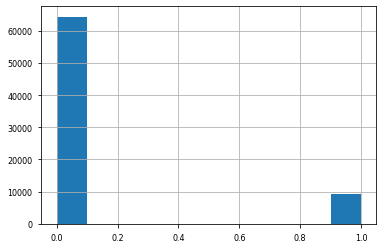

In [40]:
df.default.hist();

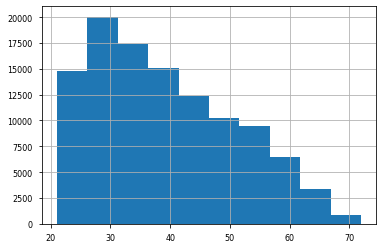

In [41]:
df.age.hist();

In [42]:
df['age'] = np.log(df['age'] + 1)

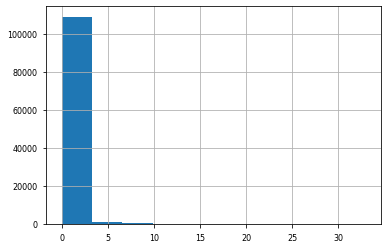

In [43]:
df.decline_app_cnt.hist();

In [44]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

Резюме - decline_app_cnt: Распределение логнормальное - взяли логарифм, выбросов очень много даже после логарифмирования, поэтому удалять их пока не будем. Построим модель, а потом вернемся к этому вопросу при необходимости.

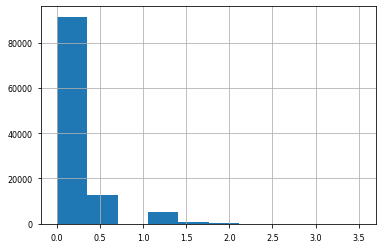

In [45]:
df.decline_app_cnt.hist();

In [46]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

Резюме - bki_request_cnt: Распределение логнормальное - взяли логарифм, выбросов не много, не стали удалять

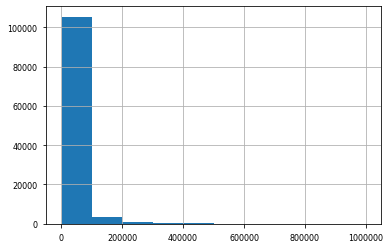

In [47]:
df.income.hist();

In [48]:
df['income'] = np.log(df['income'] + 1)

Резюме - income: Распределение логнормальное - взяли логарифм, выбросов очень много и слева и справа даже после логарифмирования, поэтому удалять их пока не будем. Построим модель, а потом вернемся к этому вопросу при необходимости.

df.score_bki.hist();

Резюме - score_bki: Распределение нормальное. Выбросов не много, не стали удалять

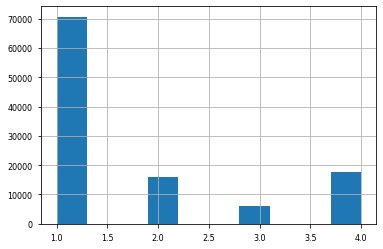

In [49]:
df.sna.hist();

Резюме - sna: Распределение смещено вправо - скорее логнормальное. Но не стали пока брать логарифм. Выбросов нет. Всего 4 значения решили использовать как категориальный признак.

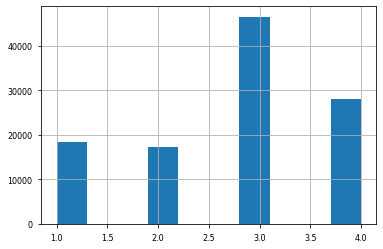

In [50]:
df.first_time.hist();

Резюме - first_time: Распределение смещено влево - нормальное. Выбросов нет. Всего 4 значения решили использовать как категориальный признак.

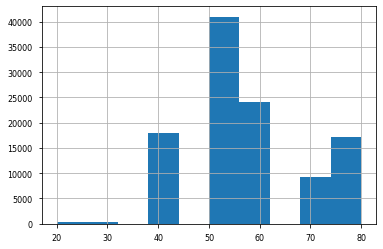

In [51]:
df.region_rating.hist();

Резюме - region_rating: Распределение скорее логнормальное. Выбросов слева в кол-ве 506 по рейтингу региона 30 и 20 в кол-ве 506 в принципе можно было бы удалить, но посмотрим сначала как сработает модель без удаления потом удалим. Справа выбросов очень много но возможно после удаления значений слева распределение сместиться вправо и при логорифмировании выбросы пропадут. Решили использовать как категориальный признак.

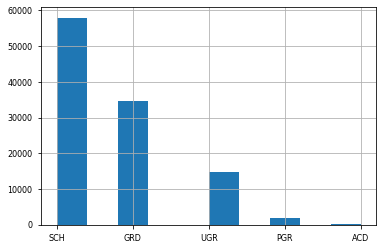

In [52]:
df.education.hist();

In [53]:
# заполним пропуски в education
# переменной education 307 (0.4%) пропущенных значений 
# заполним пропуски самым популярным значением 
df['education'] = df['education'].fillna('SCH')

In [54]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [55]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [56]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

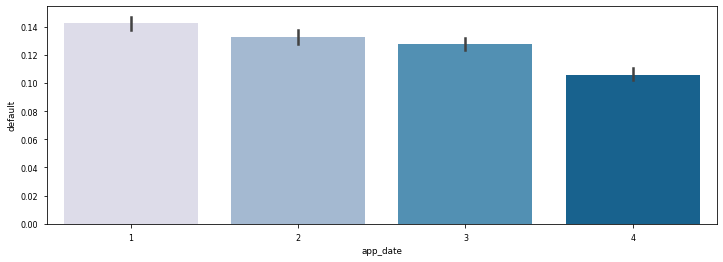

In [57]:
# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default', palette="PuBu");

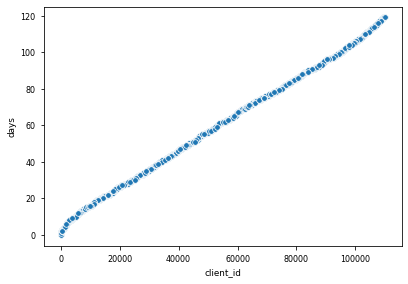

In [58]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=df)

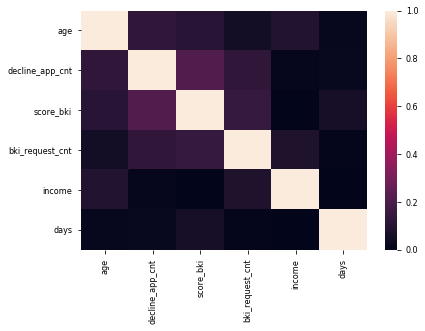

In [60]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Резюме - сильно скорелированных между собой признаков нет, все берем в работу

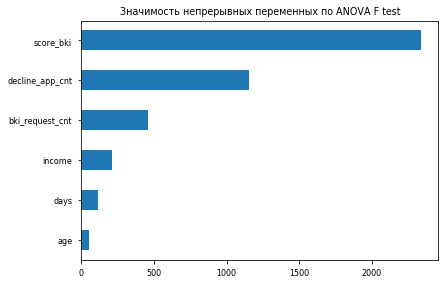

In [61]:
temp_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_l']


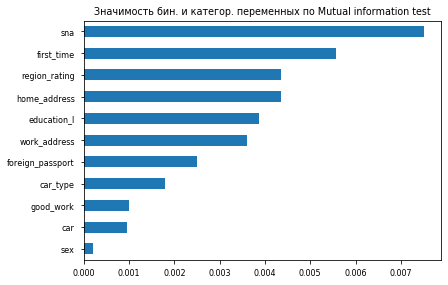

In [62]:
label_encoder = LabelEncoder()
df['education_l'] = label_encoder.fit_transform(df['education'])

# паралельно подготовим бинарные переменные и переведем их в числовой формат
# для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# тут могут быть потенциальные даталики, но мы пока не придумали как это обработать,
# потому что далее по этим меткам формируются новые фичи по get_dummies

all_cat_and_bin_cols = cat_cols+bin_cols
all_cat_and_bin_cols.remove('education')
all_cat_and_bin_cols.append('education_l')
print(all_cat_and_bin_cols)

temp_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

In [63]:
# реализуем метод OneHotLabels через get_dummies
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)


In [64]:
display(df.head(2))

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,education_l,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,4.143135,1,1,0.0,0,-2.008753,0.693147,9.798183,0,0.0,1,31,3,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,4.094345,0,0,0.0,0,-1.532276,1.386294,9.852247,0,0.0,1,70,3,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0


In [65]:
df.drop(['app_date', 'education_l'], axis=1, inplace=True)

In [66]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [67]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [68]:

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

In [69]:
# первая модель на автомате
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
m=vis_data['default'].value_counts() 
print("Общее количество \n", m)
print("Общее количество дефолтных:", m[1])

Общее количество 
 0    64155
1     9337
Name: default, dtype: int64
Общее количество дефолтных: 9337


In [70]:
default_group=df.groupby('default') 

In [71]:
default_group['age'].value_counts()

default  age     
0.0      3.465736    2380
         3.367296    2343
         3.433987    2322
         3.401197    2290
         3.332205    2282
                     ... 
1.0      4.234107      27
         4.219508      25
         4.248495       7
         4.262680       7
         4.290459       1
Name: age, Length: 103, dtype: int64

In [72]:
default_group['decline_app_cnt'].value_counts()

default  decline_app_cnt
0.0      0.000000           54509
         0.693147            6820
         1.098612            1867
         1.386294             656
         1.609438             294
         1.791759             122
         1.945910              79
         2.079442              34
         2.302585              15
         2.197225               9
         2.397895               6
         2.484907               6
         2.639057               3
         2.564949               2
         2.833213               2
         2.708050               1
         3.218876               1
         3.526361               1
1.0      0.000000            6705
         0.693147            1577
         1.098612             601
         1.386294             247
         1.609438             120
         1.791759              43
         1.945910              34
         2.079442              14
         2.197225              10
         2.302585               9
         2.397895      

In [73]:
default_group['bki_request_cnt'].value_counts()

default  bki_request_cnt
0.0      0.000000           17540
         0.693147           16105
         1.098612           11929
         1.386294            7849
         1.609438            4776
                            ...  
1.0      3.401197               1
         3.496508               1
         3.737670               1
         3.828641               1
         3.850148               1
Name: bki_request_cnt, Length: 64, dtype: int64

In [74]:
default_group['income'].value_counts()

default  income   
0.0      10.308986    6135
         10.126671    5228
         9.903538     4663
         10.596660    4355
         10.819798    4037
                      ... 
1.0      12.468441       1
         12.506181       1
         13.527830       1
         13.592368       1
         13.629182       1
Name: income, Length: 1231, dtype: int64

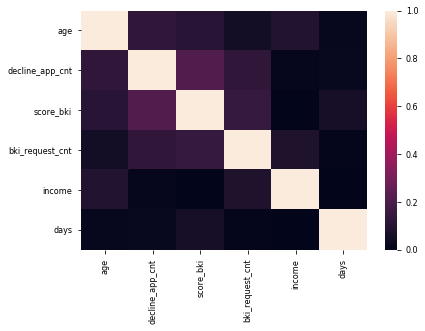

In [75]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [77]:
df.corr()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
client_id,1.000000,-0.033333,0.017342,-0.022271,-0.024695,-0.022520,0.003447,-0.061653,-0.008626,0.002900,-0.013739,-0.039242,0.002844,0.999581,-0.000222,0.031792,-0.002091,-0.050430,0.031338,0.003024,-0.004653,-0.008062,0.003060,0.001381,-0.002338,0.004711,-0.182347,0.190167,-0.032556,-0.078084,-0.140950,0.179965,0.006758,-0.010024,-0.003767,0.003123,0.009287,-0.021229,-0.024239,0.037276
sex,-0.033333,1.000000,-0.125320,0.277470,0.224822,0.022335,-0.044026,-0.046214,-0.052160,0.305326,0.085924,0.019619,-0.005135,-0.033811,0.017238,0.022769,0.019994,-0.040150,0.017589,-0.023470,-0.012078,-0.051163,-0.043214,-0.006790,0.045934,0.087714,-0.036289,0.033477,0.010375,-0.062010,-0.022596,0.060769,-0.000473,0.008966,-0.004159,-0.005375,-0.015820,0.006459,-0.002517,0.010985
age,0.017342,-0.125320,1.000000,-0.031962,-0.029295,-0.128624,-0.069063,-0.109169,0.050241,-0.090734,-0.034717,-0.026119,0.003929,0.017643,0.005450,-0.062413,-0.002924,0.168590,-0.161594,0.013202,0.010450,0.048238,0.039828,-0.006008,-0.047201,-0.062900,-0.001058,-0.000375,0.005516,0.015808,-0.001708,-0.008624,0.104267,-0.082083,-0.065776,-0.016675,-0.024537,-0.082823,-0.016294,0.108566
car,-0.022271,0.277470,-0.031962,1.000000,0.698760,-0.039005,0.001565,-0.043080,-0.045470,0.323183,0.106893,-0.043161,-0.002382,-0.022468,0.023503,0.109157,0.066957,-0.119598,-0.002624,-0.010881,-0.011222,-0.029880,-0.026220,0.001092,0.023280,0.049803,0.025902,-0.026069,0.000984,-0.004355,0.019000,-0.014662,0.064902,-0.008561,-0.018171,-0.065529,-0.079398,-0.022534,0.026573,0.056512
car_type,-0.024695,0.224822,-0.029295,0.698760,1.000000,-0.050902,0.016160,-0.042107,-0.016938,0.369761,0.145373,-0.057484,-0.003309,-0.024865,0.033088,0.153081,0.086565,-0.157802,-0.015459,-0.011590,-0.011721,-0.032034,-0.051686,-0.024867,0.051977,0.093662,0.011631,-0.011246,-0.001336,-0.001172,-0.000149,0.000893,0.078137,-0.013672,-0.021906,-0.075641,-0.087207,-0.025082,0.024861,0.067254
decline_app_cnt,-0.022520,0.022335,-0.128624,-0.039005,-0.050902,1.000000,-0.035002,0.207342,0.127531,-0.013959,-0.029009,0.124027,0.004420,-0.022499,-0.007983,-0.046968,-0.014401,0.019795,0.041753,0.008557,0.008472,0.020691,0.010205,0.007377,-0.006182,-0.041040,-0.011948,0.011419,0.001884,-0.019621,0.000221,0.012451,-0.074289,0.030934,0.034088,0.046361,0.046006,0.046090,-0.010049,-0.066376
good_work,0.003447,-0.044026,-0.069063,0.001565,0.016160,-0.035002,1.000000,0.005063,0.007833,0.052399,0.048491,-0.043361,-0.002376,0.003295,0.040373,0.157439,0.049290,-0.163817,0.000431,0.015692,0.007864,-0.021661,-0.044319,-0.012082,0.022318,0.074087,0.009517,-0.009811,0.001259,0.034274,-0.029695,0.005201,0.053815,-0.019387,-0.019312,-0.039868,-0.047012,-0.019065,0.014095,0.040096
score_bki,-0.061653,-0.046214,-0.109169,-0.043080,-0.042107,0.207342,0.005063,1.000000,0.141600,0.002592,-0.020069,0.175369,-0.000538,-0.061969,-0.017010,-0.021618,-0.018661,0.000482,0.038432,-0.004102,0.002563,0.011199,-0.015205,-0.013083,0.026952,0.003245,-0.018309,0.019495,-0.004816,-0.009936,-0.011634,0.017105,-0.075929,0.036742,0.032669,0.043830,0.029692,0.043998,0.010896,-0.074449
bki_request_cnt,-0.008626,-0.052160,0.050241,-0.045470,-0.016938,0.127531,0.007833,0.141600,1.000000,0.078649,-0.006940,0.078501,-0.001597,-0.008747,-0.005758,0.033997,-0.003341,-0.006956,-0.034073,0.001904,-0.000505,0.005479,0.000110,0.010266,0.013096,-0.027639,-0.001424,0.001011,0.001577,0.004681,-0.002738,-0.000501,-0.009871,0.004709,-0.002817,0.010202,-0.009792,-0.003659,0.011299,-0.001396
income

In [82]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 0, 1: 1}


In [84]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in num_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,1,41,1,1,0,0,42678,1,418,0,0.0,1,31,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,0,38,0,0,0,0,78151,3,436,0,0.0,1,70,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,25887,1,4,1,0,2,0,84919,1,621,1,0.0,1,31,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,16222,0,32,0,0,0,0,38892,2,196,0,0.0,1,22,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,101655,1,27,0,0,0,1,91851,1,621,1,0.0,1,107,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


In [89]:
mp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols],df['default'],discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

KeyError: "['work_address', 'sna', 'first_time', 'education', 'home_address', 'region_rating'] not in index"

In [94]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

KeyError: "None of [Index(['education', 'region_rating', 'home_address', 'work_address', 'sna',\n       'first_time'],\n      dtype='object')] are in the [columns]"

In [95]:
X_num = StandardScaler().fit_transform(df[num_cols].values)

In [96]:
X = np.hstack([X_num, df[num_cols].values, X_cat])
Y = df['default'].values

NameError: name 'X_cat' is not defined

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

NameError: name 'Y' is not defined

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


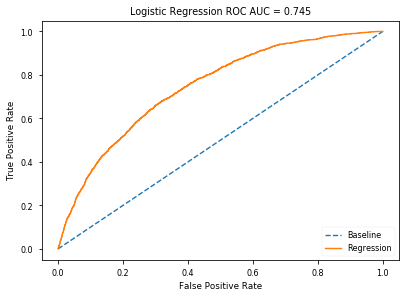

In [98]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [99]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Лучшее Penalty: l2
Лучшее C: 1291.5496650148827


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
